In [ ]:
import sys
from pathlib import Path

print(sys.executable)
print(Path.cwd())

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost import plot_importance, to_graphviz
from imblearn.pipeline import Pipeline as ImblearnPipeline
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [9]:
from sklearn.metrics import confusion_matrix, average_precision_score, recall_score, precision_score, f1_score

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics

from datetime import datetime
import itertools

# Confusion matrix:
# | TP FP |
# | FN TN |
#
# Recall: TP/(TP+FN)
# Precision: TP/(TP+FP)
# F-Score: (2*recall*precision)/(recall+precision)
def print_report(y_test, y_pred, matrix_file=None, report_file=None):
    # print(f'AUPRC = {average_precision_score(y_test, y_pred)}')

    cf_matrix = confusion_matrix(y_test, y_pred)

    precision_v = precision_score(y_test, y_pred, average='binary')
    recall_v = recall_score(y_test, y_pred, average='binary')
    f1_score_v = f1_score(y_test, y_pred, average='binary')
    
    if report_file is None:
        print(f"Precision: {precision_v}")
        print(f"Recall: {recall_v}")
        print(f"F-Score: {f1_score_v}")
    else:
        with open(report_file, 'w') as report_f:
            report_f.write(f"Precision: {precision_v}\n")
            report_f.write(f"Recall: {recall_v}\n")
            report_f.write(f"F-Score: {f1_score_v}\n")

    plt.subplots(figsize=(8, 5))
    sns.heatmap(cf_matrix, annot=True, cbar=False, fmt="g")
    if matrix_file is None:
        plt.show()
    else:
        plt.savefig(matrix_file)
        plt.cla()

    return precision_v, recall_v, f1_score_v


def print_roc_curve(y_test, y_pred, file=None):
    
    roc_auc = roc_auc_score(y_test, y_pred)
    # print(f'Roc Auc Score: {roc_auc}')
    
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
 
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k-')
    plt.plot(fpr, tpr, label='Score = {:.3f}'.format(roc_auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')

    if file is None:
        plt.show()
    else:
        plt.savefig(file)
        plt.cla()


def print_auc_curve(y_test, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=2)
    print(f'AUC score: {metrics.auc(fpr, tpr)}')


def print_corr_matrix(d):
    f, ax = plt.subplots(figsize=(10, 8))
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 12)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 12)
    sns.set(font_scale=1.3)
    sns.heatmap(
        d.corr(),
        cmap=sns.diverging_palette(220, 10, as_cmap=True),
        vmin=-1.0,
        vmax=1.0,
        square=True,
        ax=ax,
        annot=True,
        # annot_kws={'size': 26}
    )

def plot_is_fraud(data):
    ax = sns.countplot(data=data, x='IsFraud', hue='IsFraud')
    total = len(data.IsFraud)
    for p in ax.patches:
        if p._height == 0:
            continue

        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)

    plt.show()

def plotStrip(data, x, y, hue, legend_cols, figsize = (14, 9)):    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(data=data, x=x, y=y, hue=hue, jitter=0.4, marker='.', size=5, palette=colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 26)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, legend_cols, bbox_to_anchor=(1, 1), loc=2, borderaxespad=0, fontsize = 26)

    return ax

def train_model(max_epochs, optimizer, loss_fn, model, eps=0.01):
    start = datetime.now()

    train_loss = []
    validation_loss = []
    actual_epochs = max_epochs
    avg_train_loss_prev = 0.0
    for epoch in range(max_epochs):
        epoch_train_loss = 0.0
        for X_, y_ in train_dataloader:
            # zero the parameter gradients
            optimizer.zero_grad()
    
            # forward + backward + optimize
            pred = model(X_)
            loss = loss_fn(pred, y_.unsqueeze(-1))
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

        epoch_validation_loss = 0.0
        for X_, y_ in validation_dataloader: 
            target = model(X_)
            loss = loss_fn(target, y_.unsqueeze(-1))
            epoch_validation_loss += loss.item()
        
        avg_train_loss = epoch_train_loss/len(train_dataloader)
        train_loss.append(avg_train_loss)
        
        avg_validation_loss = epoch_train_loss/len(validation_dataloader)
        validation_loss.append(avg_validation_loss)
        
        print(f'Finished epoch {epoch+1}, train loss {avg_train_loss}, validation loss {avg_validation_loss}')

        if abs(avg_train_loss - avg_train_loss_prev) <= eps:
            actual_epochs = epoch
            break

        avg_train_loss_prev = avg_train_loss

    end = datetime.now()
    elapsed = (end - start).total_seconds()
    print(f"Training Complete in {elapsed}s")

    return model, train_loss, validation_loss, elapsed, actual_epochs

def _to_numpy(arr):
    return list(itertools.chain(*arr))


def test_model(model, test_dl, threshold=0.5):
    y_pred = []
    y_outputs = []
    y_test = []
    total = 0
    correct = 0
    with torch.no_grad():
        for X_, y_ in test_dl:
            outputs = model(X_)
            y_outputs.append(outputs)
            predicted = np.where(outputs < threshold, 0, 1)
            predicted = list(itertools.chain(*predicted))
            y_pred.append(predicted)
            y_test.append(y_)
            total += y_.size(0)
            correct += (predicted == y_.numpy()).sum().item()
    
    print('Testing done.')

    return _to_numpy(y_test), _to_numpy(y_pred), _to_numpy(y_outputs)

def print_loss_plot(num_epochs, train_loss_v, validation_loss_v, file=None):
    fig, ax = plt.subplots(figsize=(10, 7))
    plt.plot(np.linspace(0, num_epochs, len(train_loss_v)), np.array(train_loss_v), label='train', linewidth=5.0)
    plt.plot(np.linspace(0, num_epochs, len(validation_loss_v)), np.array(validation_loss_v), label='validation', linewidth=5.0)
    # plt.title("Step-wise Loss")
    plt.xlabel("Epochs", fontsize=22)
    plt.ylabel("Loss", fontsize=22)
    plt.legend(fontsize=22)
    if file is None:
        plt.show()
    else:
        plt.savefig(file)
        plt.cla()

class DisableWarning:
    def __init__(self, category):
        self._category = category

    def __enter__(self):
        warnings.filterwarnings('ignore', category=self._category)
        return self._category

    def __exit__(self, exc_type, exc_value, traceback):
        warnings.filterwarnings('always', category=self._category)

In [3]:
# Dataset soruce: https://www.kaggle.com/datasets/ealaxi/paysim1
df = pd.read_csv('dataset.csv')
print(df.head())
print('\n')

df = df.rename(columns={
    'isFraud': 'IsFraud',
    'step': 'Time',
    'type': 'Type',
    'amount': 'Amount',
    'nameOrig': 'PayerName',
    'oldbalanceOrg': 'PayerOldBalance',
    'newbalanceOrig': 'PayerNewBalance',
    'nameDest': 'RecipientName',
    'oldbalanceDest': 'RecipientOldBalance',
    'newbalanceDest': 'RecipientNewBalance',
    'isFlaggedFraud': 'IsFlaggedFraud',
})
print(df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


   Time      Type    Amount    PayerName  PayerOldBalance  PayerNewBalance  \
0     1   PAYMENT   9839.

In [4]:
# Dataset check scripts

def get_transactions_by_is_fraud(datafarme, is_fraud):
    return datafarme.loc[datafarme.IsFraud == int(is_fraud)]

def get_percentage_by_is_fraud(dataframe, is_fraud):
    txns = get_transactions_by_is_fraud(dataframe, is_fraud)
    return round((len(txns) * 100.0) / len(dataframe), 2)

def check_dataset_for_nulls(dataframe):
    return dataframe.isnull().values.any()


In [5]:
print(f'Genuine: {len(get_transactions_by_is_fraud(df, False))} ({get_percentage_by_is_fraud(df, False)}%)')
print(f'Fraud: {len(get_transactions_by_is_fraud(df, True))} ({get_percentage_by_is_fraud(df, True)}%)')
print(f'Contains nulls: {check_dataset_for_nulls(df)}')
print(f'Transactions total: {len(df)}, fraudulent: {len(get_transactions_by_is_fraud(df, True))}')

Genuine: 6354407 (99.87%)
Fraud: 8213 (0.13%)
Contains nulls: False
Transactions total: 6362620, fraudulent: 8213


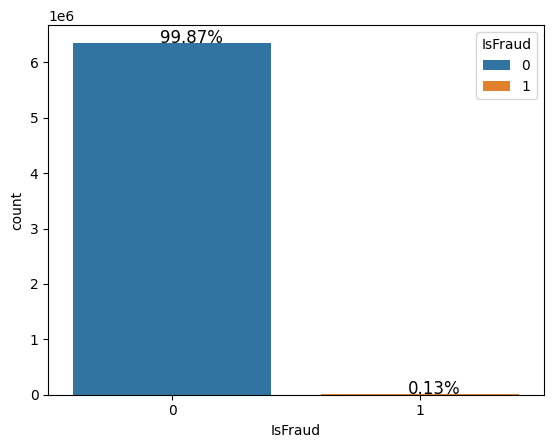

In [6]:
plot_is_fraud(df)

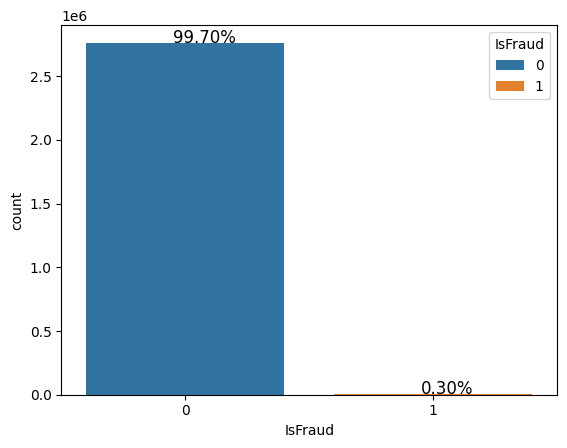

Unique payer names: 2768630
Unique recipient names: 509565

Genuine: 99.7%
Fraud: 0.3%


In [7]:
import seaborn as sns

X = df.loc[(df.Type == 'TRANSFER') | (df.Type == 'CASH_OUT')]

plot_is_fraud(X)

random_state = 37
np.random.seed(random_state)

print(f'Unique payer names: {len(list(X.PayerName.drop_duplicates()))}')
print(f'Unique recipient names: {len(list(X.RecipientName.drop_duplicates()))}')

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['PayerName', 'RecipientName', 'IsFlaggedFraud'], axis = 1)
# X = X.drop(['is_flagged_fraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.Type == 'TRANSFER', 'Type'] = 0
X.loc[X.Type == 'CASH_OUT', 'Type'] = 1
X.Type = X.Type.astype(int) # convert dtype('O') to dtype(int)

X['PayerBalanceErr'] = X.PayerNewBalance + X.Amount - X.PayerOldBalance
X['RecipientBalanceErr'] = X.RecipientOldBalance + X.Amount - X.RecipientNewBalance

X.loc[(X.RecipientOldBalance == 0) & (X.RecipientNewBalance == 0) & (X.Amount != 0), ['RecipientOldBalance', 'RecipientNewBalance']] = -1

new_df = X.copy(deep=True)

Y = X['IsFraud']
del X['IsFraud']

print()
print(f'Genuine: {round((len(Y.loc[Y == 0]) * 100.0) / len(Y), 2)}%')
print(f'Fraud: {round((len(Y.loc[Y == 1]) * 100.0) / len(Y), 2)}%')

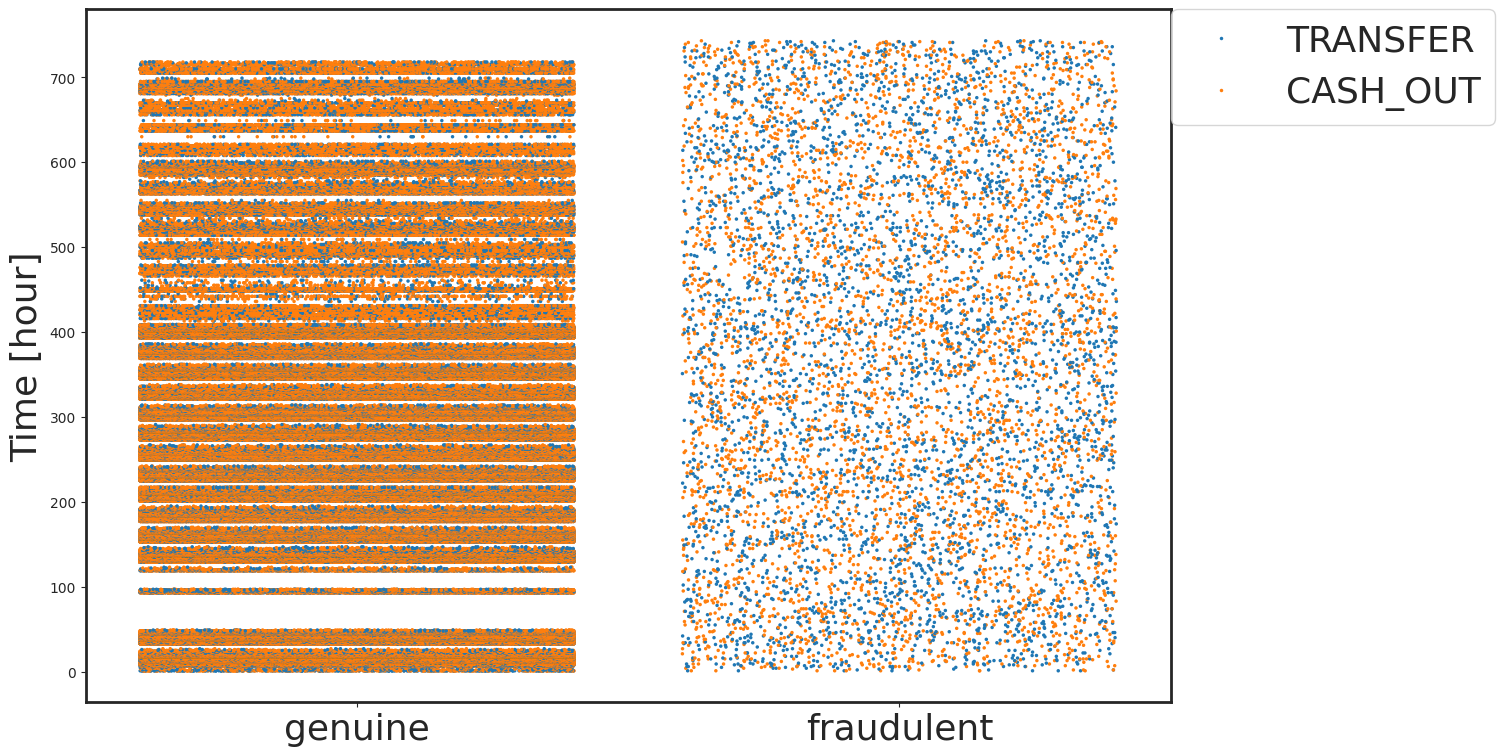

In [10]:
limit = len(X)

with DisableWarning(UserWarning):
    ax = plotStrip(
        pd.concat([Y[:limit], X.Time[:limit], X.Type[:limit]], axis='columns'),
        'IsFraud',
        'Time',
        'Type',
        ['TRANSFER', 'CASH_OUT']
    )
    ax.set_ylabel('Time [hour]', size = 26)

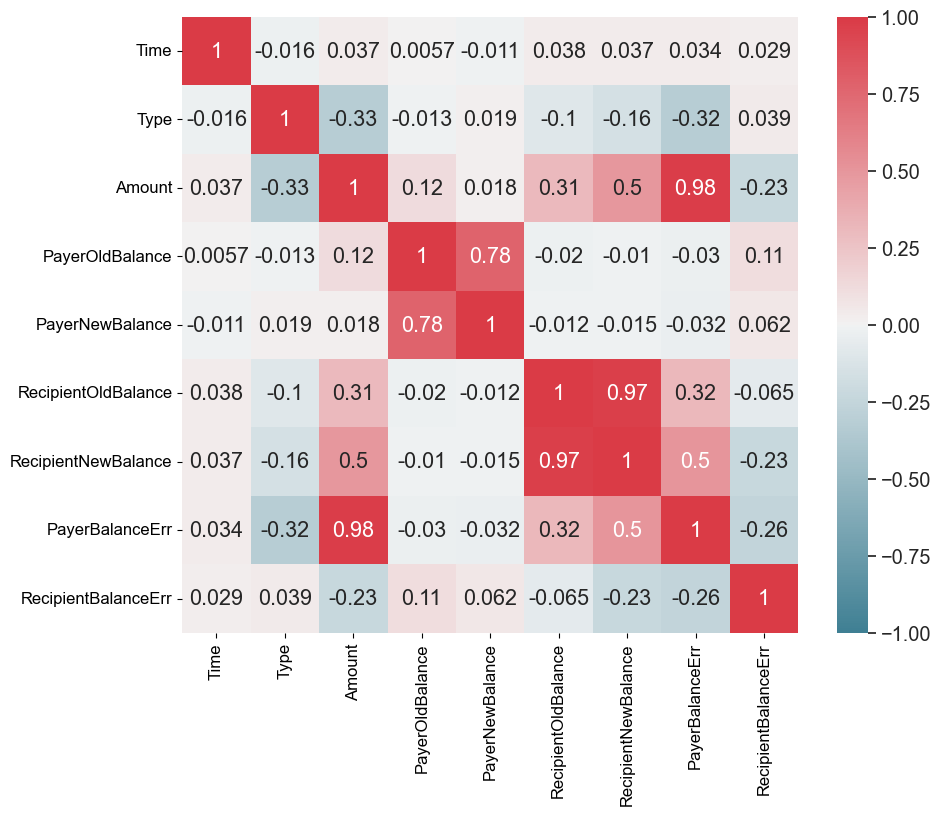

In [11]:
with DisableWarning(UserWarning):
    print_corr_matrix(X)

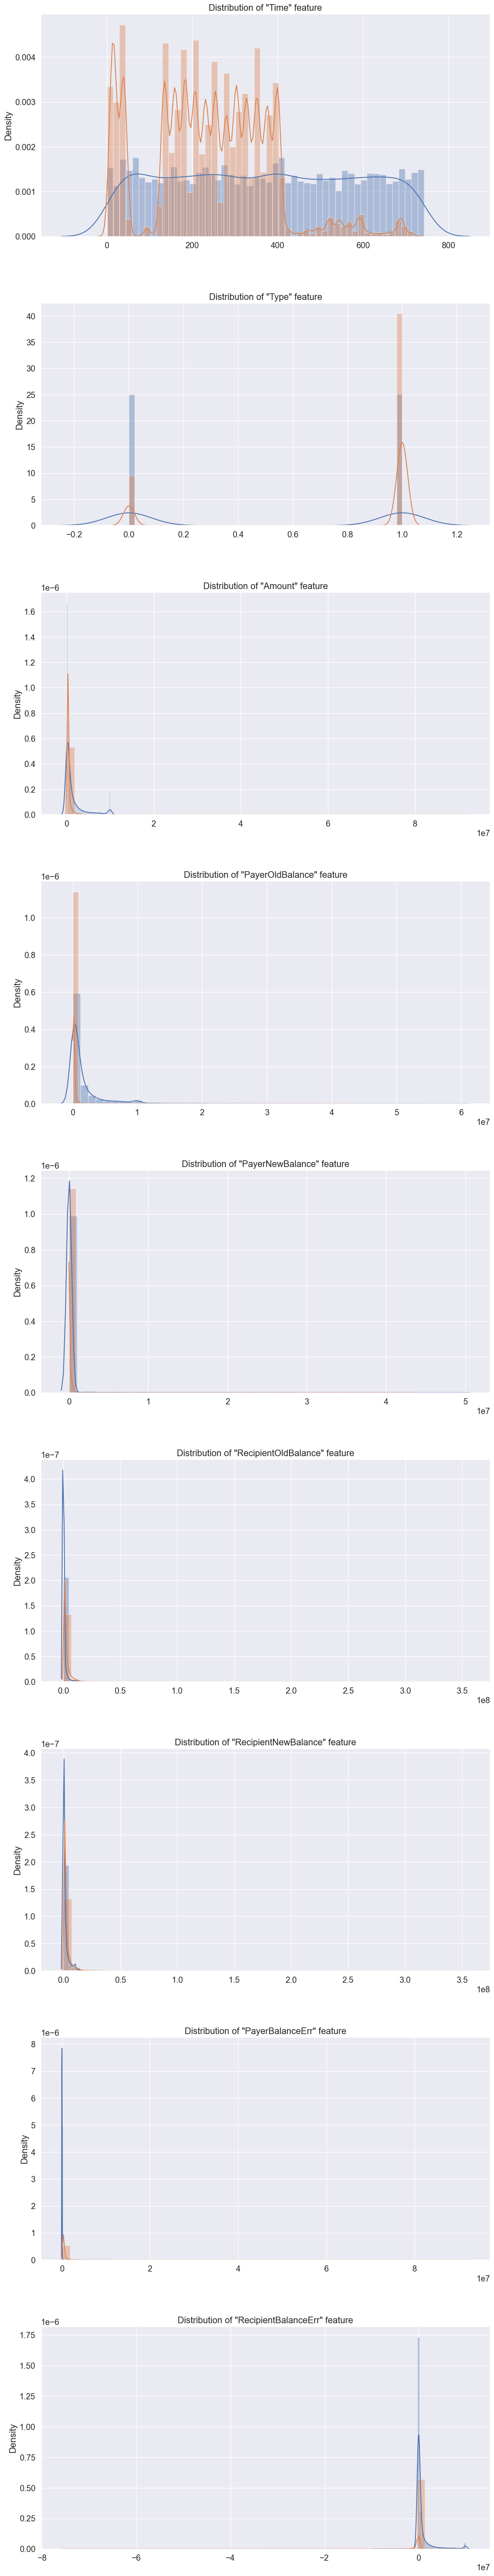

In [25]:
v_features = new_df.iloc[:,0:10].columns.drop('IsFraud')

with DisableWarning(UserWarning):
    fig = plt.figure(figsize=(14,28*len(v_features)))
    gs = gridspec.GridSpec(28, 1)
    for i, cn in enumerate(new_df[v_features]):
        ax = plt.subplot(gs[i])
        sns.distplot(new_df[cn][new_df.IsFraud == 1], bins=50)
        sns.distplot(new_df[cn][new_df.IsFraud == 0], bins=50)
        ax.set_xlabel('')
        ax.set_title(f'Distribution of "{cn}" feature')

    fig.subplots_adjust(hspace=0.3)

    plt.show()

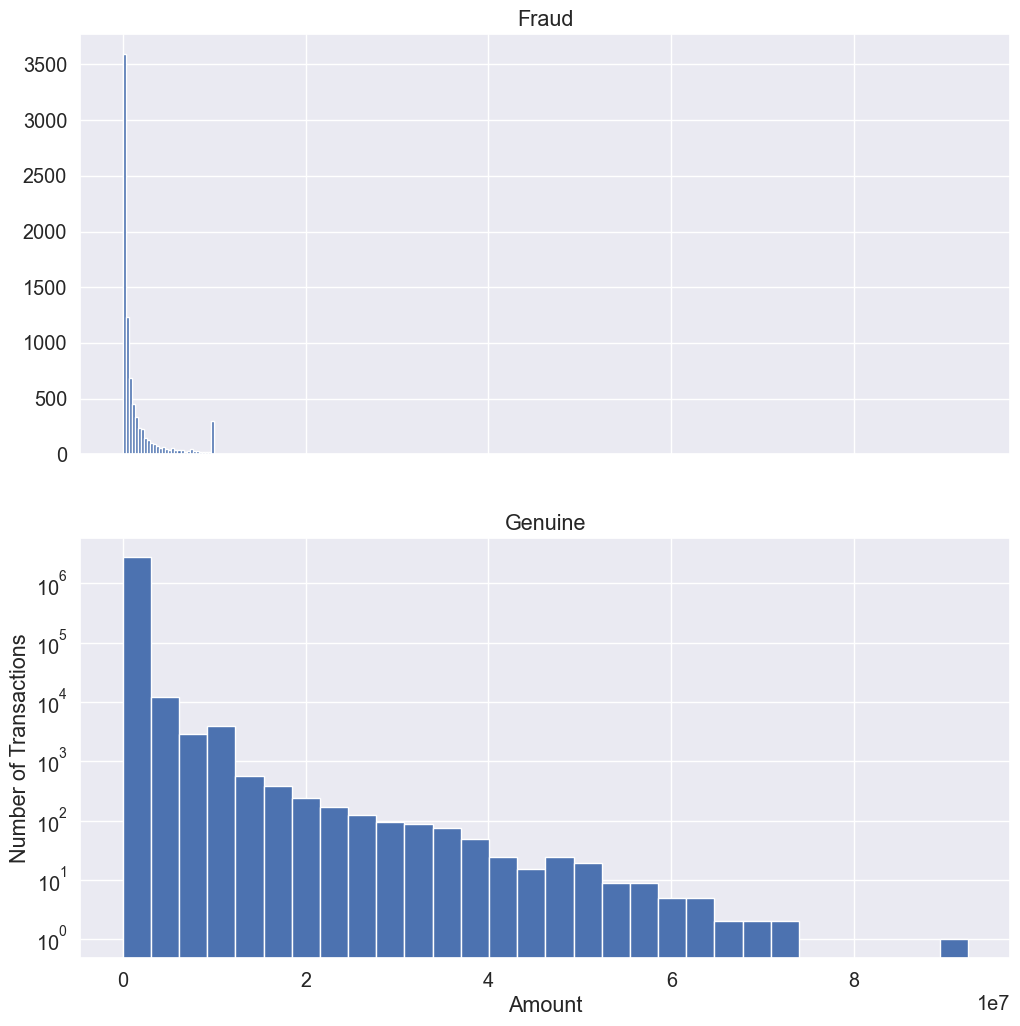

In [26]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,12))

bins = 30

ax1.hist(new_df.Amount[new_df.IsFraud == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(new_df.Amount[new_df.IsFraud == 0], bins = bins)
ax2.set_title('Genuine')

plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

In [12]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Convert data to torch tensors
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(np.array(X.astype(np.float32)))
        self.y = torch.from_numpy(np.array(y.astype(np.float32)))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

In [13]:
import torch
from torch import nn
from torch import optim

class NeuralNetwork(nn.Module):
    def __init__(self, in_dim, hidden_dim_1, hidden_dim_2, out_dim):
        super(NeuralNetwork, self).__init__()

        self.layer_1 = nn.Linear(in_dim, hidden_dim_1)
        nn.init.kaiming_uniform_(self.layer_1.weight, nonlinearity="sigmoid")
        self.layer_1_act = nn.functional.relu
        self.layer_1_dropout = nn.Dropout(0.2)
        # self.layer_1_bn = nn.BatchNorm1d(hidden_dim_1)

        self.layer_2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        nn.init.kaiming_uniform_(self.layer_2.weight, nonlinearity="sigmoid")
        self.layer_2_act = nn.functional.relu
        
        # self.layer_2_dropout = nn.Dropout(0.2)
        # self.layer_2_bn = nn.BatchNorm1d(hidden_dim_2)

        self.layer_out = nn.Linear(hidden_dim_2, out_dim)
        self.sigmoid = nn.functional.sigmoid

    def forward(self, x):
        # x = self.layer_1_act(self.layer_1_dropout(self.layer_1_bn(self.layer_1(x))))
        # x = self.layer_2_act(self.layer_2_dropout(self.layer_2_bn(self.layer_2(x))))
        x = self.layer_1_act(self.layer_1_dropout(self.layer_1(x)))
        # x = self.layer_2_act(self.layer_2_dropout(self.layer_2(x)))
        
        x = self.layer_2_act(self.layer_2(x))
        
        x = self.layer_out(x)
        x = self.sigmoid(x)

        return x


In [14]:
from sklearn import preprocessing

X_norm = preprocessing.normalize(X)

In [15]:
train_ratio = 0.70
# validation_ratio = 0.3
# test_ratio = 0.10

train_X, val_X, train_Y, val_Y = train_test_split(X_norm, Y, test_size=1-train_ratio, random_state=random_state)

# val_X, test_X, val_Y, test_Y = train_test_split(
#     test_X, test_Y, test_size=test_ratio/(test_ratio+validation_ratio), random_state=random_state
# )

print(f'Validation Y fraudulent: {len(val_Y.loc[val_Y == 1])}')
print(f'Validation Y genuine: {len(val_Y.loc[val_Y == 0])}')

Validation Y fraudulent: 2413
Validation Y genuine: 828710


In [16]:
batch_size = 2048

# Instantiate training and test data
train_data = Data(train_X, train_Y)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# test_data = Data(test_X, test_Y)
# test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

validation_data = Data(val_X, val_Y)
validation_dataloader = DataLoader(dataset=validation_data, batch_size=batch_size, shuffle=True)

# Check it's working
for batch, (X_norm, Y) in enumerate(train_dataloader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X_norm.shape}")
    print(f"y shape: {Y.shape}")
    break

Batch: 1
X shape: torch.Size([2048, 9])
y shape: torch.Size([2048])


In [17]:
input_dim = X_norm.shape[1]
hidden_dim_1 = 11
hidden_dim_2 = 5
output_dim = 1

max_num_epochs = 23

In [21]:
model = NeuralNetwork(input_dim, hidden_dim_1, hidden_dim_2, output_dim)
print(model)

model, train_loss, validation_loss, elapsed, actual_epochs = train_model(
    max_epochs=max_num_epochs,
    optimizer=torch.optim.Adam(model.parameters(), lr=0.005),
    loss_fn = nn.BCELoss(),
    model=model,
    eps=0.000001
)

torch.save(model.state_dict(), f'model_{max_num_epochs}_epochs.pth')

NeuralNetwork(
  (layer_1): Linear(in_features=9, out_features=11, bias=True)
  (layer_1_dropout): Dropout(p=0.2, inplace=False)
  (layer_2): Linear(in_features=11, out_features=5, bias=True)
  (layer_out): Linear(in_features=5, out_features=1, bias=True)
)
Finished epoch 1, train loss 0.04807302267944643, validation loss 0.1121309174321078
Finished epoch 2, train loss 0.00988538497901564, validation loss 0.0230577822047483
Finished epoch 3, train loss 0.007872040562135972, validation loss 0.018361631557494495
Finished epoch 4, train loss 0.006784872500050849, validation loss 0.01582579866391171
Finished epoch 5, train loss 0.006123591130641176, validation loss 0.014283351725904418
Finished epoch 6, train loss 0.005821541309825793, validation loss 0.013578816799027157
Finished epoch 7, train loss 0.005441961861930988, validation loss 0.012693443062188782
Finished epoch 8, train loss 0.0051914386276006716, validation loss 0.012109094532851814
Finished epoch 9, train loss 0.0051240722708

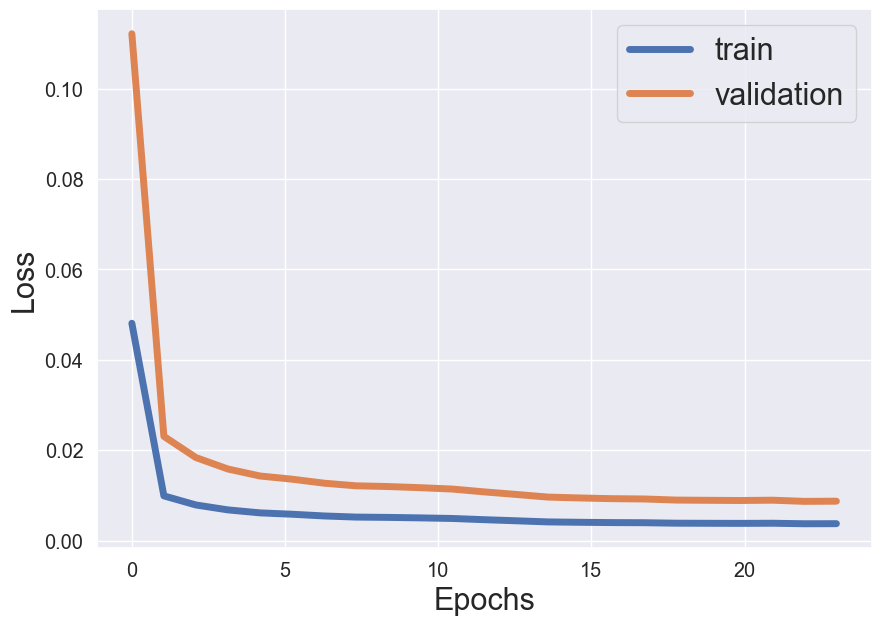

In [22]:
print_loss_plot(num_epochs=actual_epochs, train_loss_v=train_loss, validation_loss_v=validation_loss)

Testing done.
Precision: 0.9651272384542884
Recall: 0.8487360132615002
F-Score: 0.9031973539140022


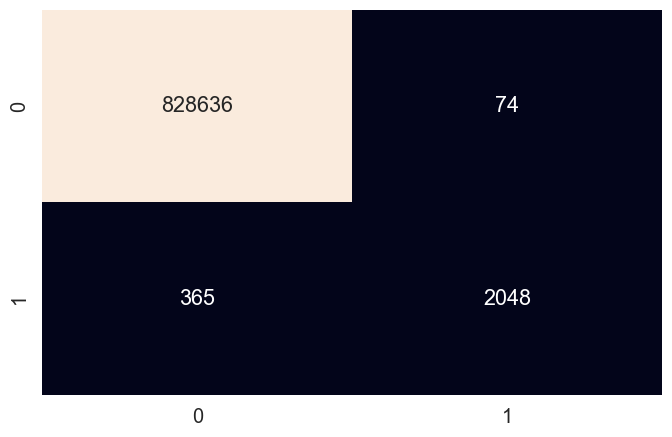

In [23]:
y_test, y_pred, y_outputs = test_model(model=model, test_dl=validation_dataloader, threshold=0.5)
_, _, _ = print_report(y_test, y_pred)